<a href="https://colab.research.google.com/github/IagoSiccardi/Aprendizaje-Automatico/blob/main/2_Modelado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo practico Introducción al aprendizaje automatico, segunda entrega.

Grupo 2:
* Lautaro Quinteros Amicone | lauti.q.a@gmail.com
* Federico Melograna | F.melograna@hotmail.com
* Iago Siccardi | iago.siccardi@gmail.com

 El [Dataset](https://data.buenosaires.gob.ar/dataset/departamentos-venta/resource/juqdkmgo-7031-resource):

Relevamiento muestral en base a datos provistos por Argenprop de los avisos publicados para la venta de departamentos usados y a estrenar en el año 2016. Se detalla el valor de publicación, metros cuadrados, antigüedad, cantidad de ambientes, ubicación, entre otras variables.

El objetivo del presente trabajo es predecir los precios de los departamentos ubicados en Capital Federal.
Para ello, nos valdremos de distintas variables, tanto numéricas como categóricas, que consideramos tienen influencia en el mismo.
Inicialmente, buscamos detectar que variables numéricas tienen mayor correlación con el costo de los departamentos.
En este sentido, detectamos que los metros cuadrados del departamento tienen una correlación alta con el precio. Por este motivo, decidimos elegir esta variable como la predictora principal.
A continuación, buscaremos comprender la influencia de otras variables, como la ubicación y numero de ambientes en nuestra variable objetivo.


⚠️ Aclaración: Separaremos el 80% de los datos para entrenar los modelos y el 20% restante lo utilizaremos para evaluar la precisión de los mismos.

Tambien se eliminaran los outliers utilizando la regla de las sigmas.

In [ ]:
# @title
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import root_mean_squared_error, r2_score

df = pd.read_excel("/content/departamentos-en-venta-2016-2da-entrega.xlsx")

std = 47.193391
media =  68.46700
sigma_3 = media + (std * 3)

df = df[df["m2"] <= sigma_3]

In [ ]:
# @title
mapa_comunas_a_zona_simple = {
    # ZONA NORTE (Comuna 2, 13, 14)
    2: 'norte',
    13: 'norte',
    14: 'norte',

    # ZONA CENTRAL (Comuna 1, 3, 6)
    1: 'central',
    3: 'central',
    6: 'central',

    # ZONA OESTE (Comuna 5, 10, 11, 15)
    5: 'oeste',
    10: 'oeste',
    11: 'oeste',
    15: 'oeste',

    # ZONA SUROESTE (Comuna 9, 12)
    9: 'suroeste',
    12: 'suroeste',

    # ZONA SUR (Comuna 4, 7, 8)
    4: 'sur',
    7: 'sur',
    8: 'sur'
}

df['zona'] = df['comuna'].map(mapa_comunas_a_zona_simple)

In [ ]:
# @title
#Nomalización de antiguedad

def antiguedad_normalizada (año):
    if len(str(año)) >= 4:
      return 2016-año
    else:
      return año
antiguedad_normalizada(df.antiguedad)

df["antiguedad"] = df["antiguedad"].apply(antiguedad_normalizada)

In [ ]:
# @title
X = df.drop(columns= {"dolares"})
y = df["dolares"]
X_train_base, X_test_base, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dando un vistazo a los graficos realizados en la anterior entrega, decidimos proponer como modelo de referencia o Benchmark una regresión lineal evaluando la relación entre la superficie en $m^2$ y el precio en USD de las propiedades.   

La ordenada en este caso es 0 y el peso de la variable superficie en $m^2$ es 2653.57. Lo que significa que por cada $m^2$ que aumente la superficie el precio de la propiedad, en promedio, aumentara 2654 USD.

Cuando evaluamos este primer modelo, con las métricas *RMSE* y $r^2$ con los datos de test, se observo un RMSE de 79620.53 USD, un valor de error muy elevado y valor de 0.63 para el $r^2$ indicando un correlación media alta entra la variable target y $m^2$.

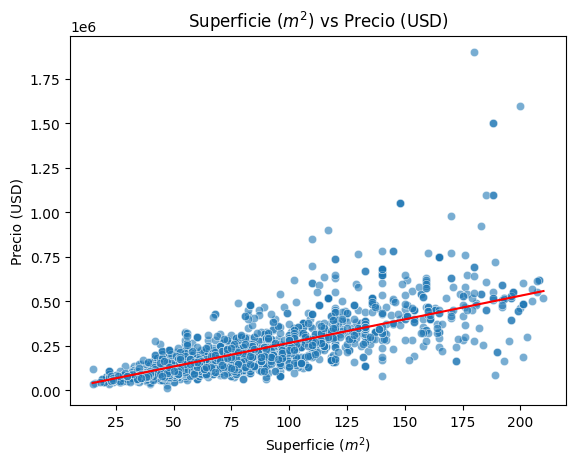

In [ ]:
# @title

X_train_df = X_train_base[["m2"]]
X_train_serie = X_train_base["m2"]
X_test_df = X_test_base[["m2"]]

model = LinearRegression(fit_intercept=False)
model.fit(X_train_df,y_train)

sns.scatterplot(x=X_train_serie, y=y_train, alpha=0.6)
sns.lineplot(x=X_train_serie, y=model.predict(X_train_df), color="red")
plt.title("Superficie ($m^2$) vs Precio (USD)")
plt.ylabel("Precio (USD)")
plt.xlabel("Superficie ($m^2$)")

rmse_benchmark = root_mean_squared_error(y_test, model.predict(X_test_df))
r2_benchmark = r2_score(y_test, model.predict(X_test_df))

# print(model.coef_)
# print("RMSE",root_mean_squared_error(y_test, model.predict(X_test_df)))
# print("R2", r2_score(y_test, model.predict(X_test_df)))

La estrategía que utilizaremos para seleccionar las variables predictoras sera mediante regularización Lasso, un metodo de regularización que disminuye el peso de las variables llevandolas a 0.

Por esto, tras elegir el valor optimo de $\lambda$ medidante validación cruzada, las variables mas influyentes en el precio de las propiedades son las siguientes:


*   $m^2$
*   Baños y ambientes (variables relacionadas a $m^2$)
*   Zona (una nueva variable obtenida a partir de agrupar geograficamente las comunas)
*   Antiguedad




In [ ]:
X_train=X_train_base[["m2", "baños", "ambientes", "zona", "antiguedad"]]

variables_categoricas=["zona"]
variables_numericas=["m2", "baños", "ambientes", "antiguedad"]
transformador_numericas = StandardScaler()
transformador_categoricas = OneHotEncoder(handle_unknown='ignore')
preprocesador = ColumnTransformer(
    transformers=[
        ('num', transformador_numericas, variables_numericas),
        ('cat', transformador_categoricas, variables_categoricas)
    ],

    remainder='passthrough'
)

modelo_base_lasso = Pipeline(steps=[
    ('preprocesador', preprocesador),
    ('lasso', LassoCV(alphas=np.logspace(-4, 2, 50), cv=5, random_state=42))
])
modelo_final = TransformedTargetRegressor(
    regressor=modelo_base_lasso,
    transformer=StandardScaler()
)

modelo_final.fit(X_train, y_train)
modelo_base_ajustado = modelo_final.regressor_
alpha_optimo = modelo_base_ajustado.named_steps['lasso'].alpha_
coeficientes_lasso = modelo_base_ajustado.named_steps['lasso'].coef_
preprocesador_ajustado = modelo_base_ajustado.named_steps['preprocesador']
nombres_numericas = variables_numericas
nombres_categoricos_codificados = preprocesador_ajustado.named_transformers_['cat'].get_feature_names_out(variables_categoricas).tolist()

nombres_totales = nombres_numericas + nombres_categoricos_codificados

df_coeficientes = pd.DataFrame({
    'Variable': nombres_totales,
    'Peso (Coeficiente)': coeficientes_lasso
})

df_coeficientes.head(10)

,Variable,Peso (Coeficiente)
0,m2,0.790213
1,baños,0.095659
2,ambientes,-0.050500
3,antiguedad,-0.102822
4,zona_central,0.069630
5,zona_norte,0.408144
6,zona_oeste,-0.000000
7,zona_sur,-0.002327
8,zona_suroeste,-0.036125


En el paso previo logramos ver la relación entre la zona del departamento y el precio del mismo. Es por ello que este primer modelo se vera definido como:

 $\hat{Y} = \beta_0 + \beta_1 \cdot m^2 + \beta_2 \cdot Zona$

Luego los datos se diviran separando nuestra variable target (dolares) de las variables predictoras. Las ultimas serán preprocesadas con los siguientes parametros:

*   Variables numéricas: seran estandarizadas con StandarScaler, la mayoría de los datos estaran en el intevalo [-1,1] y su media será 0.
*   Variables categóricas: seran codificadas binariamente con One Hot Encoder para poder agregarlas a este nuevo modelo Lineal multiple.  

In [ ]:
X_train= X_train_base[["zona","m2"]]
X_test= X_test_base[["zona","m2"]]

variables_categoricas=["zona"]
variables_numericas=["m2"]

#Definimos los transformadores para el pipeline.
transformador_numericas = StandardScaler()
transformador_categoricas = OneHotEncoder(handle_unknown='ignore')

preprocesador = ColumnTransformer(
    transformers=[
        ('num', transformador_numericas, variables_numericas),
        ('cat', transformador_categoricas, variables_categoricas)
    ],

    remainder='passthrough'
)


Ya definido el preprocesador, generamos un modelo base que encapsula la transformacción de las features y la regresión lineal y despues un modelo final que utilizara el modelo base anterior y estandariza nuestra variable target para que se encuentre en el mismo rango de valores que las variables predictoras.


In [ ]:
modelo_base = Pipeline(steps=[('preprocesador', preprocesador), ('regression', LinearRegression(fit_intercept=False))])

modelo_final = TransformedTargetRegressor(
    regressor=modelo_base,
    transformer=StandardScaler()
)

Por ultimo, tras evaluar nuestro modelo lineal con $m^2$ y "Zona" como variables predictoras realizando 5 validaciones cruzadas, obtuvimos un *RMSE* medio de 69734.55 y un $r^2$ medio de 0.69. Y al evaluarlo con los datos de prueba se obtuvo un $r^2$ de 0.68 y un *RMSE* de 75064 USD.

In [ ]:
scores = cross_validate(modelo_final, X_train, y_train, cv=5, scoring=["neg_root_mean_squared_error", "r2"])
modelo_final.fit(X_train, y_train)
rmse_prueba = round(-np.mean(scores["test_neg_root_mean_squared_error"]),3)
r2_prueba = round(np.mean(scores["test_r2"]),2)

#Evalución del modelo con datos de test.

y_test_pred = modelo_final.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)

En la gráfica donde se comparan los valores reales contra los valores predichos se puede ver que mientras la propiedad aumenta la cantidad total de $m^2$, el modelo sobreestima el precio de las propiedades.

<Axes: title={'center': 'Valor real vs Valor predicho'}, xlabel='Valor real', ylabel='Valor predicho'>

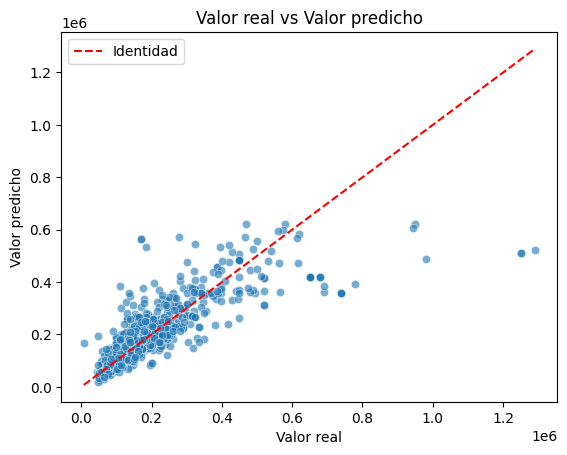

In [ ]:
# @title

r2_modelo_1 = r2_score(y_test, y_test_pred)
rmse_modelo_1 = root_mean_squared_error(y_test, y_test_pred)

min_val = min(np.min(y_test), np.min(y_test_pred))
max_val = max(np.max(y_test), np.max(y_test_pred))

sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.title("Valor real vs Valor predicho")
plt.ylabel("Valor predicho")
plt.xlabel("Valor real")
sns.lineplot(x=[min_val, max_val], y=[min_val, max_val], color='red', label="Identidad", ls="--")

Y el histograma de residuos para este modelo se encuentra centrado en 0 y muestra una forma de campana indicando poca dispersión de los datos.

Text(0, 0.5, 'Cantidad')

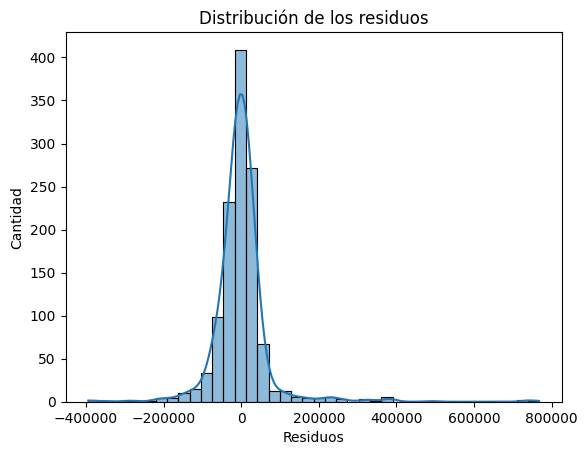

In [ ]:
# @title
residuos = y_test - y_test_pred
sns.histplot(residuos, bins=40, kde=True)
plt.title("Distribución de los residuos")
plt.xlabel("Residuos")
plt.ylabel("Cantidad")

Observando los modelos anteriores y dado que las regresiones lineales sobreestimaban el precio de las propiedades a medida que la superficie aumentaba, decidimos avanzar realizando un modelo no lineal polinomial.

 El grado del polinomio fue determinado luego de evaluar los coeficientes $r^2$ y RMSE tanto con datos de prueba y validaciones cruzadas, como con datos de test en polinomios de grado 1 a grado 5.

 En el grafico debajo, se observo el mejor rendimiento con un polinomio de grado 3 y para verificar que estabamos en lo correcto, se comparo lo observado con un GridSearch de 5 iteraciones, el cual indico que el grado 3 era el optimo.



In [ ]:
X_train= X_train_base[["zona","m2", "antiguedad", "ambientes"]]
X_test= X_test_base[["zona","m2", "antiguedad","ambientes"]]

variables_categoricas=["zona",]
variables_numericas=["m2", "antiguedad", "ambientes"]

modelo_base = Pipeline(steps=[
    ('preprocesador', preprocesador),
    ('polynomial', PolynomialFeatures()),
    ('regressor', LinearRegression(fit_intercept=False))
])

degrees = np.arange(1, 6, 1)
r2_cv = np.array([])
rmse_cv = np.array([])
r2_test = np.array([])
rmse_test = np.array([])

for degree in degrees:
    modelo_base.set_params(polynomial__degree=degree)
    scores = cross_validate(modelo_base, X_train, y_train, cv=5, scoring=["neg_root_mean_squared_error", "r2"])
    r2_cv = np.append(r2_cv, np.mean(scores['test_r2']))
    rmse_cv = np.append(rmse_cv, -np.mean(scores['test_neg_root_mean_squared_error']))

    modelo_final = TransformedTargetRegressor(
        regressor=modelo_base,
        transformer=StandardScaler()
    )

    modelo_final.fit(X_train, y_train)
    y_test_pred = modelo_final.predict(X_test)
    r2_test = np.append(r2_test, r2_score(y_test, y_test_pred))
    rmse_test = np.append(rmse_test, root_mean_squared_error(y_test, y_test_pred))


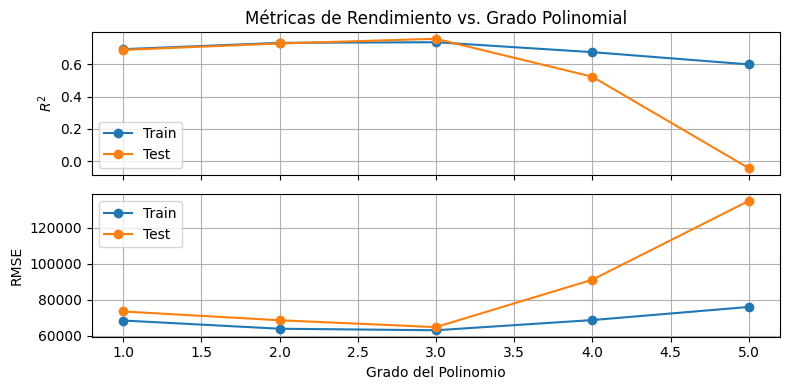

In [ ]:
# @title
fig, axs = plt.subplots(2, 1, figsize=(8, 4 ), sharex=True)

axs[0].plot(degrees, r2_cv, label="Train", marker='o')
axs[0].plot(degrees, r2_test, label="Test", marker='o')
axs[0].set_ylabel("$R^2$")
axs[0].set_title('Métricas de Rendimiento vs. Grado Polinomial')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(degrees, rmse_cv, label="Train", marker='o')
axs[1].plot(degrees, rmse_test, label="Test", marker='o')
axs[1].set_xlabel("Grado del Polinomio")
axs[1].set_ylabel("RMSE")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
parameter = {'polynomial__degree': np.arange(1, 6, 1).tolist()}

grid = GridSearchCV(modelo_base, parameter,
                    scoring=['neg_root_mean_squared_error', 'r2'],
                    refit= 'neg_root_mean_squared_error',
                    cv=5, return_train_score=True)

grid.fit(X_train, y_train)

print("Mejor parametro:")
print(grid.best_params_)

Mejor parametro:
{'polynomial__degree': 3}


Tras evaluar este ultimo modelo se obtuvo un $r^2$ de 0.76 y un RMSE de 64916.08, presentando una disminución en el error y un aumento entre la correlación de las variables. Tambien, se visualizo una mejoría al analizar la grafica de valores reales contra valores predicho.

<Axes: title={'center': 'Valor real vs Valor predicho'}, xlabel='Valor real', ylabel='Valor predicho'>

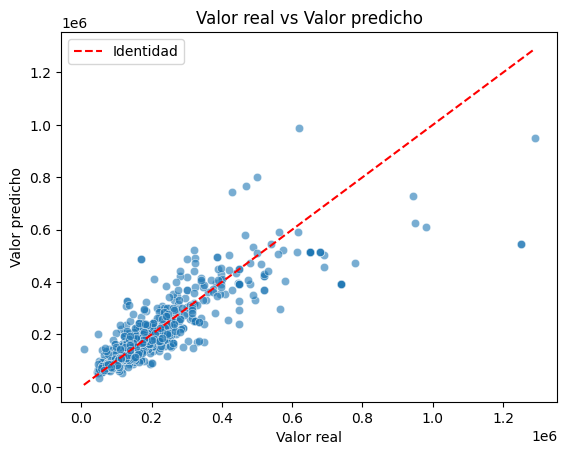

In [ ]:
# @title
modelo_base.set_params(polynomial__degree=3)

modelo_final = TransformedTargetRegressor(
        regressor=modelo_base,
        transformer=StandardScaler()
    )

modelo_final.fit(X_train, y_train)
y_test_pred = modelo_final.predict(X_test)
r2 = r2_score(y_test, y_test_pred)
rmse = root_mean_squared_error(y_test, y_test_pred)

r2_modelo_2 = r2_score(y_test, y_test_pred)
rmse_modelo_2 = root_mean_squared_error(y_test, y_test_pred)

min_val = min(np.min(y_test), np.min(y_test_pred))
max_val = max(np.max(y_test), np.max(y_test_pred))

sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.title("Valor real vs Valor predicho")
plt.ylabel("Valor predicho")
plt.xlabel("Valor real")
sns.lineplot(x=[min_val, max_val], y=[min_val, max_val], color='red', label="Identidad", ls="--")

Por ultimo, la distribución de los residuos esta centrada en 0 al igual que en el anterior modelo, pero disminuyo la dispersión de estos.

Text(0, 0.5, 'Cantidad')

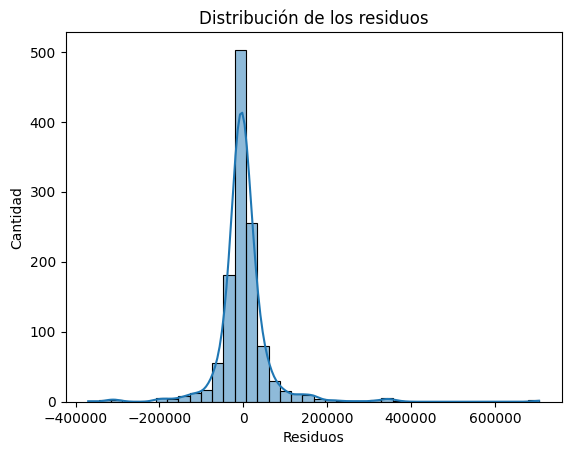

In [ ]:
# @title
residuos = y_test - y_test_pred
sns.histplot(residuos, bins=40, kde=True)
plt.title("Distribución de los residuos")
plt.xlabel("Residuos")
plt.ylabel("Cantidad")


Para la elección del modelo comparamos las metricas que utilizamos a lo largo del proyecto para evaluar el rendimiento de los mismos. Podemos ver que el modelo 2, es decir el modelo polinomial de grado 3, es el que tiene mayor $r^2$ y menor RMSE.

In [ ]:
# @title
df_resultados = pd.DataFrame({
    'Modelo': ['Benchmark','Modelo 1', 'Modelo 2'],
    'R2': [r2_benchmark, r2_modelo_1, r2_modelo_2],
    'RMSE': [rmse_benchmark,rmse_modelo_1, rmse_modelo_2]
    })

print(df_resultados)

      Modelo        R2          RMSE
0  Benchmark  0.637378  79620.530980
1   Modelo 1  0.677689  75064.634875
2   Modelo 2  0.758949  64916.085264


El trabajo se podría continuar segmentando los datos según la cantidad de $m^2$ en intervalos mas pequeños para generar modelos que puedan explicar como se comporta la relación precio/superficie en estos distintos intervalos. De esta forma, evitaríamos errores tan elevados que se observan a mayor superficie.

Tambien se podría evaluar utilizando la técnica de KNN ya que observamos que este tipo de modelos tienen mejor rendimiento que las regresiones lineales para situaciones no lineales.